# DIABETIC RETINOPATHY DETECTION

*In this notebook it will be study 3 different model arquitectures on the APTOS2018 dataset of diabetic retinopathy images for group 1 (OCULAR IMAGING)*

In [ ]:
# RUN IN COLAB
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# CHANGE TO GPU

In [ ]:

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os
from PIL import Image #Image files
import seaborn as sns

#Importing torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset,DataLoader 
from torchvision import models,transforms # Pretrained models

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Use GPU if it's available or else use CPU
print(f"The device being used is {device}") 


The device being used is cuda


# Load data

In [ ]:
%cd /content/drive/MyDrive/aptos2019blindnessdetection/

/content/drive/MyDrive/aptos2019blindnessdetection


In [ ]:
train_df = pd.read_csv("train.csv") # dataframe with an ID for each image and the corresponding diagnosis
print(f'Number of training images: {len(train_df)}')

test_df = pd.read_csv('test.csv') # ID code for test



# Function to load data into a different dataframe
def load_data():
  '''Load data'''
  train = pd.read_csv('train.csv')
  train_dir = os.path.join('train_images')
  train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
  train['file_name'] = train["id_code"].apply(lambda x: x + ".png")
  train['diagnosis'] = train['diagnosis'].astype(str)
  return train
concatenate_train = load_data()

Number of training images: 3662


>> # CSV DATA

In [ ]:
test_df.head().transpose()

,0,1,2,3,4
id_code,0005cfc8afb6,003f0afdcd15,006efc72b638,00836aaacf06,009245722fa4


In [ ]:
train_df.head().transpose()

,0,1,2,3,4
id_code,000c1434d8d7,001639a390f0,0024cdab0c1e,002c21358ce6,005b95c28852
diagnosis,2,4,1,0,0


>> ## The concatenate data is of the form


### (This dataframe will be used just for visualisation purposes)





In [ ]:
concatenate_train.tail().transpose()

,3657,3658,3659,3660,3661
id_code,ffa47f6a7bf4,ffc04fed30e6,ffcf7b45f213,ffd97f8cd5aa,ffec9a18a3ce
diagnosis,2,0,2,0,2
file_path,train_images/ffa47f6a7bf4.png,train_images/ffc04fed30e6.png,train_images/ffcf7b45f213.png,train_images/ffd97f8cd5aa.png,train_images/ffec9a18a3ce.png
file_name,ffa47f6a7bf4.png,ffc04fed30e6.png,ffcf7b45f213.png,ffd97f8cd5aa.png,ffec9a18a3ce.png


# Distribution of train data

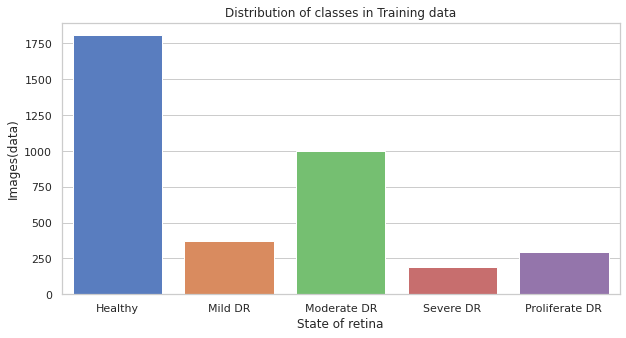

In [ ]:
#Histogram of label counts.
classes=['Healthy','Mild DR', 'Moderate DR', 'Severe DR', 'Proliferate DR']

def plot_classes(df,title, labels):
    df_group = pd.DataFrame(df.groupby('diagnosis').agg('size').reset_index())
    df_group.columns = ['State of retina','Images(data)']

    sns.set(rc={'figure.figsize':(10,5)}, style = 'whitegrid')
    ax = sns.barplot(x = 'State of retina',y='Images(data)',data = df_group,palette = "muted")
    ax.set_xticklabels(labels)
    plt.title('Distribution of classes in ' + title +' data')
    plt.show()
plot_classes(concatenate_train, 'Training',classes)

*As it can be seen the dataset (train) is higly unbalanced and it could raise a big problem in training. Training could be biased when trained on the majority classes and a lot of the images could be wrongly classified to either Healthy or Moderate DR when should not.
Therefore it is necessary to address the issue and compute weights this inverse class frequencies where each weight for each class is proportional to the inverse of the number of samples in that specific class.*

In [ ]:
from sklearn.utils import class_weight # Weights for each class (inverse number of samples in train data)
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.array([0,1,2,3,4]),y=train_df['diagnosis'].values)#classes on training set are labels as 0,1,2,3,4
class_weights = torch.tensor(class_weights,dtype=torch.float).to(device) # convert to tensor on device
 
print(f"The weigths corresponding to each class respectively are {class_weights}")

The weigths corresponding to each class respectively are tensor([0.4058, 1.9795, 0.7331, 3.7948, 2.4827], device='cuda:0')


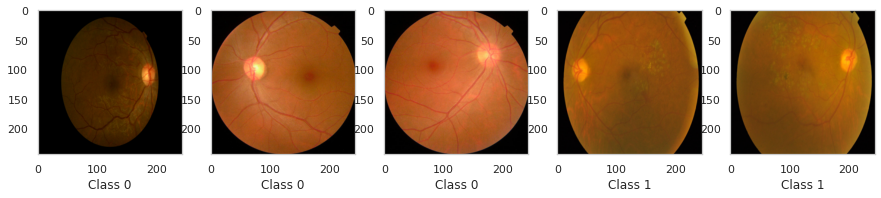

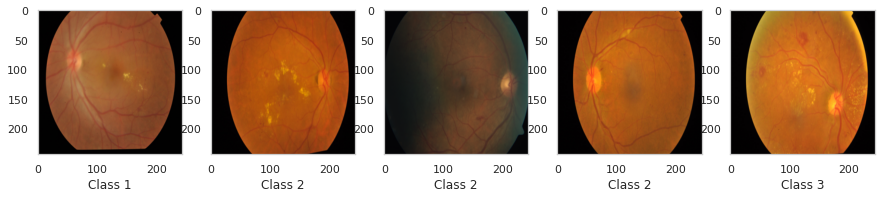

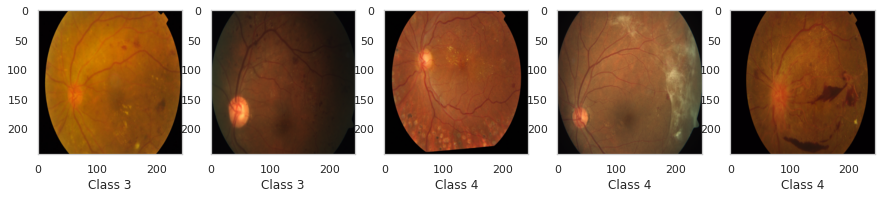

In [ ]:

size_image= 244

def display_random_samples_by_class(dataframe, num_samples_per_class, image_size):
    """
    Displays a random subset of images from each class in the given dataframe.
    Args:
        dataframe: A pandas dataframe containing image file paths and labels.
        num_samples_per_class: An integer representing the number of images to display for each class.
        image_size: An integer representing the size of the displayed images (in pixels).
    Returns:
        None
    """
    # Randomly sample a subset of the data from each class
    df = dataframe.groupby('diagnosis', group_keys=False).apply(lambda df: df.sample(num_samples_per_class))
    df = df.reset_index(drop=True)
    
    # Configure plot settings
    plt.rcParams["axes.grid"] = False
    
    # Display images for each class
    for i in range(num_samples_per_class):
        # Create a plot with 5 subplots (one for each class)
        fig, axarr = plt.subplots(1, 5, figsize=(15, 15))
        
        # Select the images for the current subset
        subset_start_index = i * 5
        df_temp = df.iloc[subset_start_index:subset_start_index+5]
        
        # Display each image in the subplot with its corresponding class label
        for j in range(5):
            axarr[j].imshow(Image.open(df_temp.file_path.iloc[j]).resize((image_size, image_size)))
            axarr[j].set_xlabel('Class '+str(df_temp.diagnosis.iloc[j]))
        
        plt.show()
display_random_samples_by_class(concatenate_train,3,size_image)

  * Class/Stage 0: No apparent retinopathy. The retina appears to be healthy.
  * Class/Stage 1: Mild retinopathy. Small areas of swelling (microaneurysms) and/or the presence of some blood vessels in the retina are visible.
  * Class/Stage 2: Moderate retinopathy. More blood vessels are blocked, and there is a greater risk of the retina being deprived of its blood supply.
  * Class/Stage 3: Severe retinopathy. Many blood vessels in the retina are blocked, which can cause significant vision loss.
  * Class/Stage 4: Proliferative retinopathy. New blood vessels begin to grow in the retina, but they are fragile and bleed to the retina, causing vision loss and/or blindness.

In [ ]:
class Dataset_DR(Dataset):
    '''
    Dataset_DR Pytorch class for the APTOS2018 dataset. Overloads its methods. 
    Uses four items to generate the dataset, Pandas dataframe (CSV file), path to images, transformations for the images and a boolean to differientiate between train/test.
    
    Args:
        df:  DataFrame (CSV file)
        data_path: Location of the dataset
        image_transform: Transformations to apply to the images
        train: A boolean stating whether it is a training_set or not

    Return:
          Image with transfrom and label or only Image(test) on dataset
    '''
    
    def __init__(self,df,data_path,image_transform=None,train=True): 
        super(Dataset,self).__init__() # Calls the constructor of the Dataset class
        self.df = df
        self.data_path = data_path
        self.image_transform = image_transform
        self.train = train
        
    def __len__(self):
        return len(self.df) # Number of samples of data
    
    def __getitem__(self,index):
        imageID = self.df['id_code'][index]
        image = Image.open(f'{self.data_path}/{imageID}.png') # Image (index)
        if self.image_transform :
            image = self.image_transform(image) # Applies transformation to the current image
        
        if self.train :
            label = self.df['diagnosis'][index] # Label for image
            return image,label # If train is True returns image and label
        
        else:
            return image # If train is False returns image only
        
        
       

In [ ]:
# Transforms to apply on the image
img_transforms = transforms.Compose([transforms.Resize([224,224]),#512 
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

dataset = Dataset_DR(train_df,'train_images',image_transform=img_transforms)

# Split the dataset into training testing and validation data 
train_set,valid_set, test_set = torch.utils.data.random_split(dataset,[3000,300,362])


In [ ]:
#Dataloaders
train_dataloader = DataLoader(train_set,batch_size=32,shuffle=True) # DataLoader for train
valid_dataloader = DataLoader(valid_set,batch_size=32,shuffle=False)# DataLoader for validation
test_dataloader = DataLoader(test_set,batch_size=32,shuffle=False)# DataLoader for test

# Different Model Arquitectures


# Model ResNet18 
**This model is  Residual Network consisting of 18 layers combining Convolutions, batchnormalization, pooling layers and fully connected layers**

In [ ]:
model = models.resnet18(pretrained=False) # ResNet18
# Final layers should match the matrix shape therefore 512 on the size of the layer and an output layer with 5 outputs
model.fc = nn.Sequential(nn.Linear(512,256),nn.Linear(256,128),nn.Linear(128,64),nn.Linear(64,5))  

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
model = model.to(device) # To device (make sure is cuda for efficency)
summary(model,(3,244,244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 122, 122]           9,408
       BatchNorm2d-2         [-1, 64, 122, 122]             128
              ReLU-3         [-1, 64, 122, 122]               0
         MaxPool2d-4           [-1, 64, 61, 61]               0
            Conv2d-5           [-1, 64, 61, 61]          36,864
       BatchNorm2d-6           [-1, 64, 61, 61]             128
              ReLU-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 61, 61]          36,864
       BatchNorm2d-9           [-1, 64, 61, 61]             128
             ReLU-10           [-1, 64, 61, 61]               0
       BasicBlock-11           [-1, 64, 61, 61]               0
           Conv2d-12           [-1, 64, 61, 61]          36,864
      BatchNorm2d-13           [-1, 64, 61, 61]             128
             ReLU-14           [-1, 64,

In [ ]:
def training(dataloader,model,loss_fn,optimizer):
    '''
    Trains the model using the optimizer given and based on the loss function.

    
    Args:
         dataloader: Loader of data
         model: Model being trained on
         loss_fn: Difference between the model prediction and the target
         optimizer: Updates parameters of the model
         
    Returns:
         avg_loss: loss of model over training epochs
         acc: accuracy of model over training epochs
    '''

    model.train() # Training mode
    
    #Initialise
    total = 0
    correct = 0
    running_loss = 0

    
    for batch,(x,y) in enumerate(dataloader): # Iterates through batches
        
        output = model(x.to(device)) # Prediction of the model (CPU)
        loss   = loss_fn(output,y.to(device)) # Loss funnction (deviation in probability)
       
        running_loss += loss.item() # Store
        
        total        += y.size(0)
        # If using a GPU change next lines 'cpu'
        predictions   = output.argmax(dim=1).cuda().detach() # Highest score on output scores
        correct      += (predictions == y.cuda().detach()).sum().item() # Predictions = target
        
        optimizer.zero_grad() # Gradients initial
        loss.backward() # Find Gradients
        optimizer.step() # Optimizing weights
        
    acc = (100*(correct/total)) # Update accuracy
             
    
    avg_loss = running_loss/len(dataloader) # Average loss for a single batch
    
    print(f'\nTraining Loss per batch = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Training set = {100*(correct/total):.6f}% ') 
    
    return avg_loss, acc

In [ ]:
def validation(dataloader,model,loss_fn):
    '''
    validate function loss and accuracy of model's predicitons
    Args:
         dataloader: Loader of data
         model: Model being trained on
         loss_fn: Difference between the model prediction and the target
    Returns:
         avg_loss: loss of model over training epochs
         acc: accuracy of model over training epochs
    '''
    
    model.eval() # Model for evaluation.
    
    total = 0
    correct = 0
    running_loss = 0

    
    with torch.no_grad(): # Gradients not calculated
        
        for x,y in dataloader:
            
            output        = model(x.to(device)) # Model's output
            loss          = loss_fn(output,y.to(device)).item() # Loss
            running_loss += loss
            
            total        += y.size(0)
            predictions   = output.argmax(dim=1).cuda().detach()
            correct      += (predictions == y.cuda().detach()).sum().item()
            
    acc = 100*(correct/total)
    avg_loss = running_loss/len(dataloader) # Loss per batch     
    
    print(f'\nValidation Loss per batch = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Validation set = {100*(correct/total):.6f}% ') 
    
    return avg_loss, acc

In [ ]:
def evaluate_model(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs):
    '''
    Trains the model and evaluates on training data to avoid overfitting along a number of epochs
    
    Args:
        train_dataloader: DataLoader for the training
        valid_dataloader: DataLoader for the validation
        optimizer: optimizes the weigths
        model: The model being used
        loss_fn: Difference between the model prediction and the target
        nb_epochs: Epochs
        
    Returns:
        train_losses: loss training
        valid_losses: loss validation
        train_acc: accuracy training
        valid_acc: accuracy validation
    '''
    #Storages
    train_losses = []
    valid_losses = []
    train_acc = []
    valid_acc = []

    for epoch in range(nb_epochs):
        print(f'\nEpoch {epoch+1}/{nb_epochs}')
        print('-------------------------------')
        train_loss, train_accuracy = training(train_dataloader,model,loss_fn,optimizer) # train function
        train_losses.append(train_loss)
        train_acc.append(train_accuracy)
        valid_loss, valid_accuracy = validation(valid_dataloader,model,loss_fn) # validate function
        valid_losses.append(valid_loss)
        valid_acc.append(valid_accuracy)
    
    print('\nTraining finished')
    
    return train_losses,valid_losses, train_acc, valid_acc

In [ ]:
def test(model, test_loader):
    '''
    Test function to evaluate the performance of the model on the test set
    
    Args:
         model: trained model
         test_loader: dataloader for the test set
         
    Returns:
         accuracy: the accuracy of the model on the test set
    '''
    model.eval() # Evaluation mode
    # Initialise
    correct = 0
    total = 0
    
    with torch.no_grad(): # No gradients
        for data in test_loader:
            images, labels = data # Get data items
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images) # Predicitons
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    # Final accuracy
    accuracy = 100 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (accuracy))
    
    return accuracy

In [ ]:

loss_fn   = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.SGD(model.parameters(),lr=0.001) 
nb_epochs = 18
#TRAINING
train_losses, valid_losses,train_acc, valid_acc  = evaluate_model(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs)


Epoch 1/18
-------------------------------

Training Loss per batch = 1.613452	Accuracy on Training set = 14.266667% 

Validation Loss per batch = 1.599371	Accuracy on Validation set = 34.000000% 

Epoch 2/18
-------------------------------

Training Loss per batch = 1.599589	Accuracy on Training set = 42.600000% 

Validation Loss per batch = 1.593817	Accuracy on Validation set = 46.000000% 

Epoch 3/18
-------------------------------

Training Loss per batch = 1.589229	Accuracy on Training set = 47.100000% 

Validation Loss per batch = 1.588473	Accuracy on Validation set = 49.666667% 

Epoch 4/18
-------------------------------

Training Loss per batch = 1.580904	Accuracy on Training set = 48.833333% 

Validation Loss per batch = 1.582529	Accuracy on Validation set = 50.666667% 

Epoch 5/18
-------------------------------

Training Loss per batch = 1.572687	Accuracy on Training set = 49.800000% 

Validation Loss per batch = 1.572125	Accuracy on Validation set = 52.000000% 

Epoch 6/1

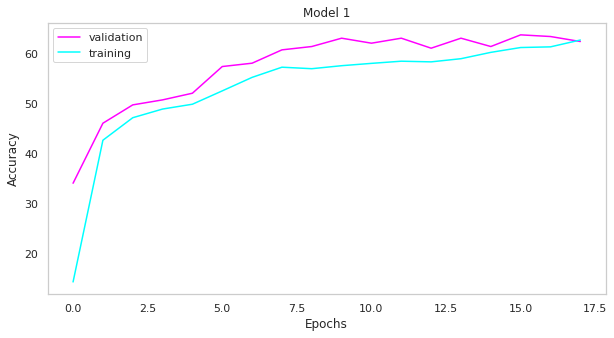

In [ ]:
#PLOTS
plt.title('Model 1')
plt.plot(valid_acc,label='validation',c='magenta')
plt.plot(train_acc,label='training',c='cyan')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
#Final accuracy for model 1
acc_model1 = test(model, test_dataloader)

Accuracy of the network on the test images: 57 %


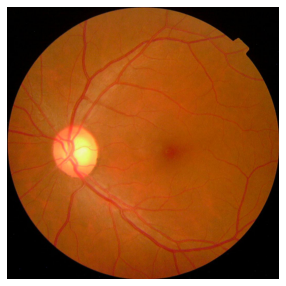

Predicted label: Healthy


In [ ]:
def classify_image(image_path, model):

    img=Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    # Define image transformations
    img_transforms = transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    # Load and transform the image
    img = Image.open(image_path).convert('RGB')
    img = img_transforms(img)
    img = img.unsqueeze(0)
    # Move input tensor to the same device as the model
    device = next(model.parameters()).device
    img = img.to(device)


    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(img)
        predicted = output.argmax(dim=1).item()
    print(f'Predicted label: {classes[predicted]}')

    return predicted
path='train_images/04579e31e4be.png'
predicted_labe_model1 = classify_image(path, model)


# Model arquitecture 2 
**This is a new Residual Network but with a few more parameters, hopefully a better performance while mainting some efficency**

In [ ]:
class Block(nn.Module):
    
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()

        # Convolution layers
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels) # Batchnormalization
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels) # Batchnormalization
        self.relu = nn.ReLU() # reLU
        # Shortcut x -> F(x)+x
        self.identity_downsample = identity_downsample
        
    def forward(self, x):
        # Store identity
        identity = x
        # Firs convolution block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # Second block
        x = self.conv2(x)
        x = self.bn2(x)

        # Shortcut connections if necessary
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity

        # reLU again
        x = self.relu(x)
        return x


class Network(nn.Module):
    
    def __init__(self, img_channels, num_classes):
        
        super(Network, self).__init__()
        self.in_channels = 64
        # First Conv. Block
        self.conv1 = nn.Conv2d(img_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Residual layers
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)
        
        # Output layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def __make_layer(self, in_channels, out_channels, stride):
        
        # Downsampling will be applied if stride is different from 1
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)

        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride), 
            Block(out_channels, out_channels)
        )
        
    def forward(self, x):
        
        # First Conv. Block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        # Residual layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # Output layers
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x 
    
    # Downsampling block
    def identity_downsample(self, in_channels, out_channels):
        # Sequential module
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(out_channels)
        )


model_2 = Network(3, 5)# input output shapes
model_2.fc = nn.Sequential(nn.Linear(512,256),nn.Linear(256,128),nn.Linear(128,64),nn.Linear(64,5))  # Same as before
model_2 = model_2.to(device) # Move the model to the device
summary(model_2,(3,244,244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 122, 122]           9,472
       BatchNorm2d-2         [-1, 64, 122, 122]             128
              ReLU-3         [-1, 64, 122, 122]               0
         MaxPool2d-4           [-1, 64, 61, 61]               0
            Conv2d-5           [-1, 64, 61, 61]          36,928
       BatchNorm2d-6           [-1, 64, 61, 61]             128
              ReLU-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 61, 61]          36,928
       BatchNorm2d-9           [-1, 64, 61, 61]             128
             ReLU-10           [-1, 64, 61, 61]               0
            Block-11           [-1, 64, 61, 61]               0
           Conv2d-12           [-1, 64, 61, 61]          36,928
      BatchNorm2d-13           [-1, 64, 61, 61]             128
             ReLU-14           [-1, 64,

In [ ]:
loss_fn   = nn.CrossEntropyLoss(weight=class_weights) #CrossEntropyLoss with class_weights.
optimizer = torch.optim.SGD(model_2.parameters(),lr=0.001) 
nb_epochs = 18

#Change to GPU
train_losses2, valid_losses2,train_acc2, valid_acc2  = evaluate_model(train_dataloader,valid_dataloader,model_2,loss_fn,optimizer,nb_epochs)


Epoch 1/18
-------------------------------

Training Loss per batch = 1.599459	Accuracy on Training set = 45.066667% 

Validation Loss per batch = 1.595688	Accuracy on Validation set = 50.333333% 

Epoch 2/18
-------------------------------

Training Loss per batch = 1.575521	Accuracy on Training set = 56.400000% 

Validation Loss per batch = 1.571999	Accuracy on Validation set = 53.333333% 

Epoch 3/18
-------------------------------

Training Loss per batch = 1.547376	Accuracy on Training set = 58.966667% 

Validation Loss per batch = 1.539497	Accuracy on Validation set = 56.333333% 

Epoch 4/18
-------------------------------

Training Loss per batch = 1.505338	Accuracy on Training set = 59.533333% 

Validation Loss per batch = 1.490346	Accuracy on Validation set = 58.333333% 

Epoch 5/18
-------------------------------

Training Loss per batch = 1.451500	Accuracy on Training set = 58.000000% 

Validation Loss per batch = 1.433273	Accuracy on Validation set = 58.333333% 

Epoch 6/1

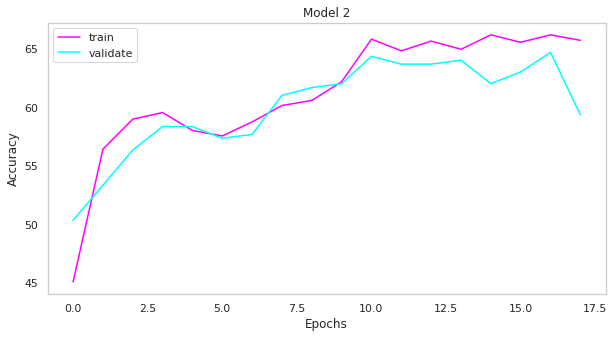

In [ ]:
plt.plot(train_acc2, c='magenta', label='train')
plt.plot(valid_acc2, c='cyan', label='validate')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model 2')
#plt.axis('off')
plt.legend()

In [ ]:
# Call the test function
acc_model2 = test(model_2, test_dataloader)


Accuracy of the network on the test images: 60 %


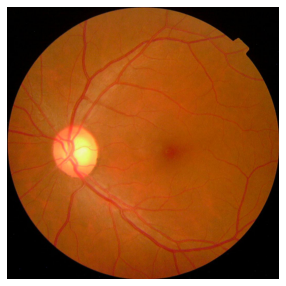

Predicted label: Healthy


In [ ]:
path='train_images/04579e31e4be.png'
predicted_label_model2 = classify_image(path, model_2)


# Model 3 
**For the final model arquitecture it will be a more complex one with many more layers the ResNet50
NOTICE THIS LAST MODEL TAKES A LOT OF TIME AND COMPUTATIONAL COST**

In [ ]:
model_3 = models.resnet50(pretrained=True) # ResNet18
# Final layers should match the matrix shape therefore 512 on the size of the layer and an output layer with 5 outputs
model_3.fc = nn.Sequential(nn.Linear(2048,256),nn.Linear(256,128),nn.Linear(128,64),nn.Linear(64,5))
model_3 = model_3.to(device) # To device (make sure is cuda for efficency)
summary(model_3,(3,244,244))  

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 122, 122]           9,408
       BatchNorm2d-2         [-1, 64, 122, 122]             128
              ReLU-3         [-1, 64, 122, 122]               0
         MaxPool2d-4           [-1, 64, 61, 61]               0
            Conv2d-5           [-1, 64, 61, 61]           4,096
       BatchNorm2d-6           [-1, 64, 61, 61]             128
              ReLU-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 61, 61]          36,864
       BatchNorm2d-9           [-1, 64, 61, 61]             128
             ReLU-10           [-1, 64, 61, 61]               0
           Conv2d-11          [-1, 256, 61, 61]          16,384
      BatchNorm2d-12          [-1, 256, 61, 61]             512
           Conv2d-13          [-1, 256, 61, 61]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
loss_fn   = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.SGD(model_3.parameters(),lr=0.001) 
nb_epochs_3 = 50
#TRAINING
train_losses_3, valid_losses_3,train_ac_3, valid_acc_3  = evaluate_model(train_dataloader,valid_dataloader,model_3,loss_fn,optimizer,nb_epochs_3)

**With this final model we get to an accuracy of 85% However the computational cost of trainign is very high compared to the other two models**

In [ ]:
plt.plot(train_acc_3, c='magenta', label='train')
plt.plot(valid_acc_3, c='cyan', label='validate')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model 3')
#plt.axis('off')
plt.legend()

In [ ]:
acc_model3 = test(model_2, test_dataloader)

In [ ]:
path='train_images/04579e31e4be.png'
predicted_label_model3 = classify_image(path, model_3)

**Load own images**

We can state that the chosen model architecture to perform classification tasks is model 2 that gets to an accuracy of 70% approximately

In [ ]:
path_new='..path..to..new..image..'
label_m = classify_image(path_new, model)
label_m2 = classify_image(path_new, model_2)
label_m3 = classify_image(path_new, model_3)